# Eric's Thesis Project

In [597]:
# System libraries
import sys, os
import datetime

# Math libraries
import math, random
import pandas as pd, numpy as np
import scipy
from scipy import stats
from datetime import timedelta

# Data storage libraries
import pickle, sqlite3, simpledbf, boto3

# Custom financial data libraries
import findata_utils as fd

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def event_timespan(d):
    if d<0:
        return 'pre-event'
    elif d>0:
        return 'post-event'
    else:
        return 'event'
    return 'err'

from importlib import reload
fd = reload(fd)

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
overleaf = ['C:','Users','bryce','OneDrive','Documents','Overleaf','5babbfe264c952737a9a5117','esc499']
conn = sqlite3.connect(db)
c = conn.cursor()

hdf_path = 'C:\\Datasets\\thesis.h5'
hdf = pd.HDFStore(hdf_path)

colors = {}
colors['pre-event'] = 'xkcd:dark salmon'
colors['post-event'] = 'xkcd:denim'

time_range = [-21,21]

# Load datasets

In [271]:
protected_venues = ['TSX','PT','CHIC','CX2','OMG']

## Load sector returns data and push to SQLite

## Get French 3-Factor Data

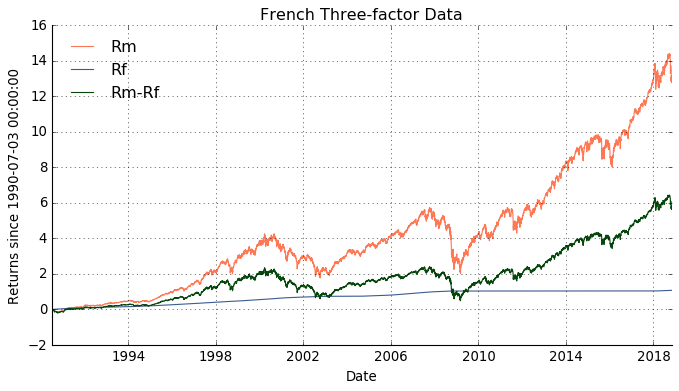

In [109]:
threefactor = fd.get_french('North_America_3_Factors_Daily')
for column in threefactor.columns[1:]:
    threefactor[column] = threefactor[column]*0.01
threefactor['Rm'] = threefactor['Mkt-RF']+threefactor['RF']
threefactor['date'] = threefactor['Date'].apply(lambda Date: datetime.datetime.strptime(str(Date),'%Y%m%d'))
threefactor['culm_Rm'] = (threefactor['Rm']+1).cumprod()

# Visualize French data to sanity check
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

plt.title('French Three-factor Data')
plt.xlabel('Date')
plt.ylabel('Returns since {Start}'.format(Start=threefactor['date'].min()))
plt.plot(threefactor['date'],((threefactor['Rm']+1).cumprod()-1),color='xkcd:melon')
plt.plot(threefactor['date'],((threefactor['RF']+1).cumprod()-1),color='xkcd:denim blue')
plt.plot(threefactor['date'],((threefactor['Mkt-RF']+1).cumprod()-1), color='xkcd:forest green')
plt.legend(['Rm','Rf','Rm-Rf'], frameon=False, loc='best')
plt.show()

## Pull price data from my local SQLite instance

In [513]:
# Query the database for close price data
px = pd.read_sql('''
    SELECT
        date,ticker,
        MAX(c) AS px,
        SUM(vol) AS vol,
        SUM(trades) AS trades
    FROM cfmrc
    WHERE ticker IN
        (SELECT ticker FROM indexchanges) 
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

# Query the database for close price data
allpx = pd.read_sql('''
    SELECT date,ticker, MAX(c) AS px
    FROM cfmrc
    GROUP BY ticker,date'''
    ,conn).drop_duplicates()

print('Obtained %d close prices' % len(px.index))

rebal_day = pd.read_sql('''
    SELECT s.date AS rebal_date, s.ticker, c AS rebal_px, flag
    FROM cfmrc s
    INNER JOIN indexchanges i
    WHERE s.date=i.date 
        AND s.ticker=i.ticker'''
    ,conn)

print('Obtained rebalance day price info for %d securities' % len(rebal_day.index))

Obtained 277212 close prices
Obtained rebalance day price info for 178 securities


### Exclude stocks which were added, then removed again (or vice-versa)

In [950]:
multiple_samples = rebal_day.groupby(by='ticker')['flag'].count().reset_index()
multiple_samples = multiple_samples[multiple_samples.flag>1].ticker.unique()

rebal_day = rebal_day[~rebal_day.ticker.isin(multiple_samples)]
if len(multiple_samples)>0:
    print('Removed {Count} securities which were both added and removed: {Tickers}'.format(Count=len(multiple_samples),
                                                                                      Tickers=', '.join(multiple_samples)))
else:
    print('Removed no duplicated samples')

Removed 26 securities which were both added and removed: ACQ, AKG, AR, AVO, BDI, BXE, CF, CLC, CXR, FRC, FVI, GUY, HNL, IAE, KDX, NAL, NVA, P, PLI, POU, PSG, PSN, RIO, SGY, TCW, WJX


## Calculate returns and factors on securities
 * __px__: closing price on a given day
 * __rebalpx__: closing price on the day of the change
 * __return__: total return since/til addition (deletion)
 * __rebal__: date of the rebalance
 * __date__: today's date
 * __flag__: addition (deletion)
 * __d__: days until (since) addition/deletion

In [951]:
# Merge rebalance data to price data
df = px.merge(rebal_day, on=['ticker'])

# Parse dates
df['date'] = df['date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
df['rebal_date'] = df['rebal_date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))

# Days unitl rebal
df['d'] = (df['date']-df['rebal_date']).apply(lambda d: d.days)
df.sort_values(by=['ticker','d'], inplace=True)

# Get directional change
df['flag'] = df['flag'].apply(lambda flag: 1 if flag==1 else -1)

# Compute price deltas
df['delta_px'] = (df['px']-df['rebal_px'])*df['flag']

# And use this to compute the culmulative daily return, indexed to the rebal day
df['return_to_rebal'] = df['delta_px']/df['rebal_px']

# Also, use this to determine daily returns per security
df['daily_return'] =(df['px'].shift(-1).diff()/df['px']).fillna(0)

# Forbid infinite returns
df = df[ ~df['daily_return'].isin([-np.Inf, np.Inf]) ]

for ticker in df['ticker'].unique():
    # Correct the first day return for each security
    df.ix[(df['ticker']==ticker) & (df['date']==df[df['ticker']==ticker]['date'].min()), 'daily_return']=0

df = df.merge(threefactor[['Rm','RF','culm_Rm','date']], on=['date'])

df['timespan'] = df['d'].apply(lambda d: event_timespan(d))

### Compute betas

In [952]:
betas = []
beta_time_horizon = 365
for ticker in df['ticker'].unique():
    
    base_filter = (df['ticker']==ticker) & (df['d'].between(-beta_time_horizon, beta_time_horizon, inclusive=True)) & (df['px']!=0)
    
    beta = pd.Series(name=ticker)
    beta['lifetime'] = df.loc[base_filter][['Rm','daily_return']].dropna().cov().iloc[0,1]
    beta['lifetime'] = beta['lifetime']/df.loc[base_filter]['Rm'].dropna().var()
    
    for timespan in ['pre-event','post-event']:
        beta[timespan] = df.loc[base_filter & (df['timespan']==timespan)][['Rm','daily_return']].dropna().cov().iloc[0,1]
        beta[timespan] = beta[timespan]/df.loc[base_filter & (df['timespan']==timespan)]['Rm'].dropna().var()
        
    betas.append(pd.DataFrame(beta).T)
betas = pd.concat(betas)#.reset_index()
#betas.columns = ['ticker', 'lifetime','pre-event','post-event']
betas = betas.stack().reset_index()
betas.columns = ['ticker','timespan','beta']

df = df.merge(betas, on=['ticker','timespan'], how='left')

lifetime_betas = betas.loc[betas['timespan']=='lifetime'][['ticker','beta']]
lifetime_betas.columns = ['ticker','lifetime_beta']
df = df.merge(lifetime_betas, on=['ticker'], how='left')
df['beta'].fillna(df['lifetime_beta'], inplace=True)

### Use these betas to adjust the returns

In [953]:
df['daily_alpha'] = df['daily_return']-df['RF']-(df['lifetime_beta']*(df['Rm']-df['RF']))
for ticker in df['ticker'].unique():
    df.loc[df['ticker']==ticker, 'culm_alpha'] = (df.loc[df['ticker']==ticker, 'daily_alpha']+1).cumprod()-1

adjustments = df[df['d']==0][['ticker','culm_alpha']]
adjustments.columns = ['ticker','culm_alpha_at_t0']
df = df.merge(adjustments, on=['ticker'])

# NEGATIVE ALPHA IMPLIES PRICE WILL GO UP BEFORE REBALANCE
# POSITIVE ALPHA IMPLIES PRICE WILL FALL BY THE REBALANCE DAY
df['alpha_to_rebal'] = df['culm_alpha_at_t0']-df['culm_alpha']

# Positive alpha implies:
#    price will fall by the rebalance day (for adds)
#    price will rise by the rebalance day (for deletes)
df['alpha_to_rebal_side-adj'] = df['alpha_to_rebal']*df['flag']
df['return_to_rebal_side-adj'] = df['return_to_rebal']*df['flag']

### Find out what happens around the ranking week

In [954]:
length_of_ranking_period = 13

df['rebal_last_eom'] = df['rebal_date'].apply(lambda rebal_date: (rebal_date-pd.Timedelta(days=30)) +pd.tseries.offsets.MonthEnd(1) )
df['rebal_ranking_end'] = df['rebal_last_eom']
df['rebal_ranking_start'] = df['rebal_ranking_end']-pd.Timedelta(days=length_of_ranking_period)

avg_days = df[['ticker','rebal_date','rebal_ranking_end','rebal_ranking_start']].drop_duplicates()
avg_days['ranking_end_to_rebal'] = avg_days['rebal_date']-avg_days['rebal_ranking_end']
avg_days = avg_days.groupby(by=['ranking_end_to_rebal']).agg({'ticker':'count'}).reset_index()
avg_days = np.sum(avg_days['ranking_end_to_rebal']*avg_days['ticker'])/np.sum(avg_days['ticker'])
avg_days = avg_days.astype('timedelta64[D]').astype(int)

# Determine ranking prices

avg_ranking_price = df.loc[df['date'].between(df['rebal_ranking_start'],
                                              df['rebal_ranking_end'])].groupby(by='ticker').agg({'px':'sum'})/10

avg_ranking_price.columns=['ranking_px']

try:
    df.drop(avg_ranking_price.columns, inplace=True)
except:
    pass

df = df.merge(avg_ranking_price, on=['ticker'], how='left')
df['return_ranking_to_rebal']=(df['rebal_px']-df['ranking_px'])/df['rebal_px']

## Deal with financing flows
Seperate rebalance from financing trades. Other securities must be sold IOT buy the adds. Reweighting and share adjustments (buy-backs). Isolate for these.

# Explore the Data
## Determine whether abnormal returns (or reversion) exist

Reversion: T+1 astonishing (i.e., wrong way on rebalance day close)... also consider T+5 vs Bechmark. Right-way reversion on Monday; possibly due to the 3-day break over the weekend.

Risk/return on inclusions. Is it an arb opprotunity? Or is there risk associated with e.g. shortage of liquidity? Understand whether short sales affect it (look at short interest for securities being included -- TMX Short Position Report)?

     d alpha_to_rebal_side-adj           return_to_rebal_side-adj          
                          mean       std                     mean       std
0 -365                0.619518  1.270599                 0.614867  1.333547
1 -364                0.613362  1.251842                 0.622525  1.341343
2 -361                0.558643  1.020476                 0.609787  1.327755
3 -360                0.572733  1.055927                 0.644676  1.395241
4 -359                0.632578  1.357955                 0.659933  1.433320


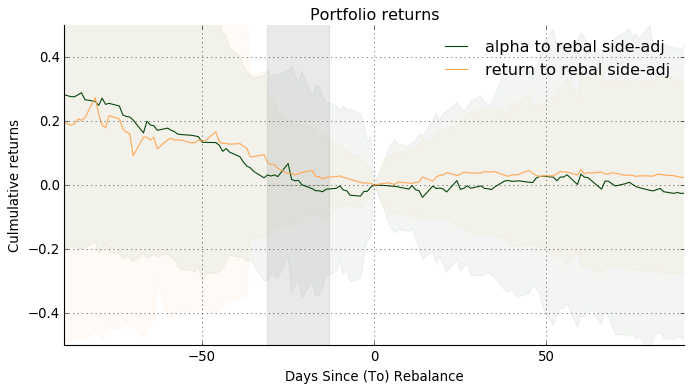

In [484]:
aggregated = df[df['d'].between(-365, 365, inclusive=True) & df['flag'].isin([-1,1]) & (~df['alpha_to_rebal'].isna())].groupby(by='d').agg({'alpha_to_rebal_side-adj':['mean','std'],
                                                                                                                                           'return_to_rebal_side-adj':['mean','std']}).reset_index()
print(aggregated.head())

# Plot it

plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

lines = {'alpha_to_rebal_side-adj':'xkcd:forest green',
        'return_to_rebal_side-adj':'xkcd:pale orange'}

for line in lines:
    ax.plot(aggregated['d'],aggregated[line]['mean'], color=lines[line])
    ax.fill_between(aggregated['d'], aggregated[line]['mean']-aggregated[line]['std'], aggregated[line]['mean']+aggregated[line]['std'], color=lines[line], alpha=0.05)

# Plot the ranking period
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [1,1], color='xkcd:grey', alpha=0.2)
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-1,-1], color='xkcd:grey', alpha=0.2)

ax.legend([line.replace('_',' ') for line in lines.keys()], frameon=False, loc='best')

plt.title('Portfolio returns')
plt.ylabel('Culmulative returns')
plt.xlabel('Days Since (To) Rebalance')

xlim = [-365,365]
#ylim = [aggregated[aggregated['d'].between(xlim[0], xlim[1], inclusive=True)][list(lines.keys())].min().min(),
#        aggregated[aggregated['d'].between(xlim[0], xlim[1], inclusive=True)][list(lines.keys())].max().max()]

plt.xlim(time_range)
plt.ylim(-0.5,0.5)
plt.show()
fig.savefig('\\'.join(overleaf+['{Factor}_returns_side-adj.png'.format(Factor=factor)]))

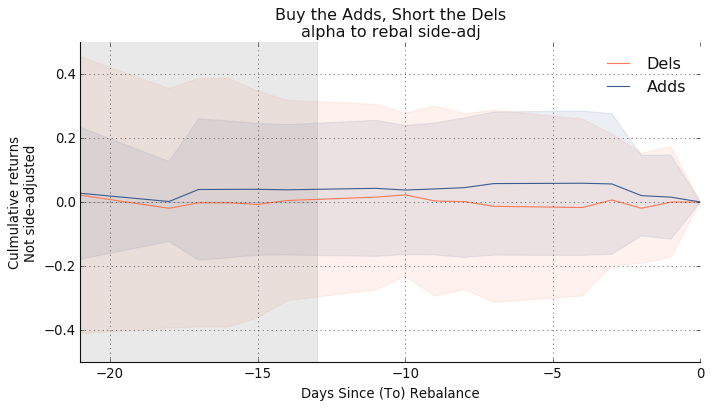

In [971]:
time_range = [-21,0]

for factor in ['alpha_to_rebal_side-adj']:

    by_side = df[df['d'].between(-365, 365, inclusive=True)].groupby(by=['d','flag']).agg({
                                     factor:['mean','std']}).reset_index()
    # Plot it
    plt.style.use('classic')

    fig = plt.figure(figsize=(10,5))
    fig.patch.set_facecolor('white')

    ax = fig.add_subplot(1, 1, 1)

    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.grid(True,axis='both',linestyle=':')

    sides = {'Dels':1,'Adds':-1}
    colors = {'Dels':'xkcd:melon','Adds':'xkcd:denim blue'}
    for side in sides.keys():

        ax.plot(by_side[by_side['flag']==sides[side]]['d'],
                by_side[by_side['flag']==sides[side]][factor]['mean']*sides[side],
                color=colors[side])

        ax.fill_between(by_side[by_side['flag']==sides[side]]['d'],
                        (by_side[by_side['flag']==sides[side]][factor]['mean']-by_side[by_side['flag']==sides[side]][factor]['std'])*sides[side],
                        (by_side[by_side['flag']==sides[side]][factor]['mean']+by_side[by_side['flag']==sides[side]][factor]['std'])*sides[side],
                        color=colors[side], alpha=0.1)

    ax.legend(sides.keys(), frameon=False, loc='best')
    
    # Plot the ranking period
    ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [1,1], color='xkcd:grey', alpha=0.2)
    ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-1,-1], color='xkcd:grey', alpha=0.2)

    plt.title('Buy the Adds, Short the Dels\n{Factor}'.format(Factor=factor.replace('_',' ')))
    plt.ylabel('Culmulative returns\nNot side-adjusted')
    plt.xlabel('Days Since (To) Rebalance')

    plt.xlim(time_range)
    plt.ylim(-0.5,0.5)
    plt.show()
    fig.savefig('\\'.join(overleaf+['{Factor}_returns_per-side_{t0}_{t1}.png'.format(Factor=factor,
                                                                                     t0=time_range[0],
                                                                                     t1=time_range[1])]))
    #plt.ylim(ylim)

### Hypothetical strategy: short the adds (buy the dels) and hedge with the market on t+1

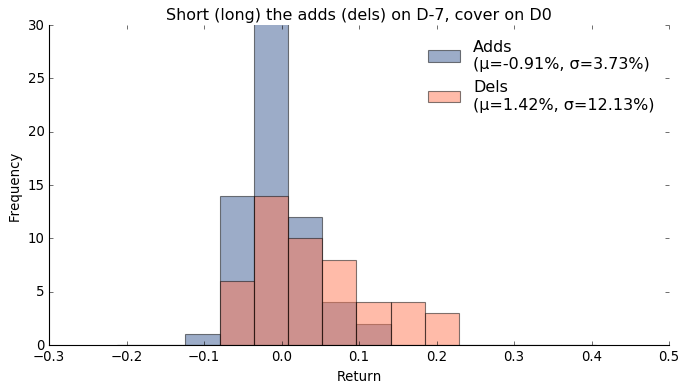

In [506]:
plt.style.use('classic')

time_range = [-7,0]

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
    
t0 = df[df['d']==time_range[0]][['ticker','rebal_date','flag','px']]
t1 = df[df['d']==time_range[1]][['ticker','px']]
delta = pd.merge(left=t0,right=t1, on=['ticker'], suffixes=['0','1'])
delta['dpx'] = delta['px1']-delta['px0']
delta['return'] = -delta['dpx']/delta['px0']*delta['flag']

bins = np.linspace(delta['return'].min(), delta['return'].max(),15)

flag_colors = {-1:'xkcd:melon',1:'xkcd:denim blue'}
side_names = {-1:'Dels',1:'Adds'}

legend = []
for flag in delta['flag'].unique():
    plt.hist(delta[delta['flag']==flag]['return']*-1, color=flag_colors[flag], alpha=0.5, bins=bins)
    legend.append('{flag}\n(μ={mean}%, σ={std}%)'.format(flag=side_names[flag],
                                                            mean=round(delta[delta['flag']==flag]['return'].mean()*-100,2),
                                                            std=round(delta[delta['flag']==flag]['return'].std()*100,2)))
plt.legend(legend, frameon=False, loc='best')
    
plt.title('Short (long) the adds (dels) on D{t0}, cover on D{t1}'.format(t0=time_range[0],
    t1=time_range[1]))
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.ylim([0,30])
plt.show()
fig.savefig('\\'.join(overleaf+['naive-strategy_{D0}-{D1}.png'.format(D0=time_range[0],D1=time_range[1])]))

### Is there a bifurcation in the deletes?

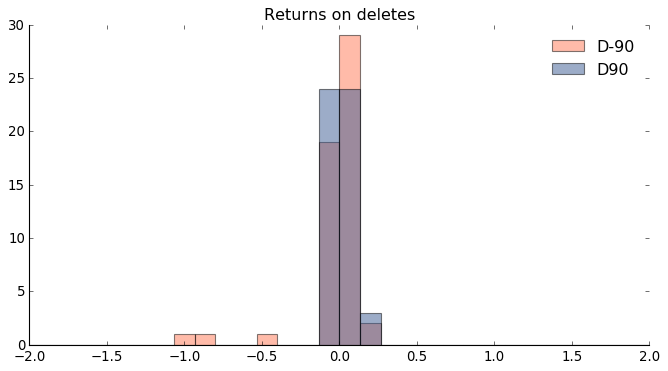

In [489]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-2,2,31)
plt.hist(df[(df['flag']==-1) & (df['d']==-21)]['alpha_to_rebal']*-1, color=flag_colors[-1], alpha=0.5, bins=bins)
plt.hist(df[(df['flag']==-1) & (df['d']==21)]['alpha_to_rebal']*-1, color=flag_colors[1], alpha=0.5, bins=bins)
plt.title('Returns on deletes')

# TODO: look at TSX60 adds/dels

plt.legend(['D{Days}'.format(Days=time_range[0])
            ,'D{Days}'.format(Days=time_range[1])], 
            frameon=False, loc='best')
plt.show()

## Calculate risk factors, per-security

In [28]:
beta = df[['date','d','ticker','daily_return','Rm']].drop_duplicates()

risk = []
for ticker in beta['ticker'].unique():
    # Calculate the risk per security
    sample = beta[beta['ticker']==ticker][['d','daily_return','Rm']]
    
    for timespan in ['lifetime','pre-event','post-event']:
        # Compute for whether or not this is before or after the rebalance event
        security_risk = pd.Series(name=ticker)
        security_risk['timespan'] = timespan
        
        if timespan=='pre-event':
            subsample=sample[sample['d']<0]
        elif timespan=='post-event':
            subsample=sample[sample['d']>0]
        else:
            subsample=sample

        slope, intercept, r_value, p_value, std_err = stats.linregress(subsample['Rm'], subsample['daily_return'])

        security_risk['intercept'] = intercept
        security_risk['beta'] = slope
        security_risk['idio'] = r_value**2

        risk.append(pd.DataFrame(security_risk).T.reset_index())
    
risk = pd.concat(risk)
risk['beta'] = risk['beta'].astype(float)
risk['idio'] = risk['idio'].astype(float)
risk['intercept'] = risk['intercept'].astype(float)

risk = risk.merge(df[['ticker','flag']].drop_duplicates(), left_on='index', right_on='ticker', how='outer')

print(risk.head(5))
hdf.put(key='risk', value=risk, format='t', append=False)

    index    timespan  intercept      beta      idio  ticker  flag
0  AAR.UN    lifetime   0.000103  0.344620  0.055522  AAR.UN     1
1  AAR.UN   pre-event  -0.000291  0.372295  0.059813  AAR.UN     1
2  AAR.UN  post-event   0.000405  0.328364  0.053134  AAR.UN     1
3    AC.B    lifetime        NaN       NaN       NaN    AC.B     1
4    AC.B   pre-event   0.000130  0.711204  0.062714    AC.B     1


### Visualize changes in risk factors

# Explore comparables and time-series
## What happens to securities which are added and then deleted, or vice versa?

In [635]:
dfm = px.loc[px['ticker'].isin(multiple_samples)].merge(rebal_day, on=['ticker'], how='left')
dfm['date'] = dfm['date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))
dfm['rebal_date'] = dfm['rebal_date'].apply(lambda date: datetime.datetime.strptime(date,'%Y-%m-%d'))

# Days unitl rebal
dfm['d'] = (dfm['date']-dfm['rebal_date']).apply(lambda d: d.days)
dfm.sort_values(by=['ticker','flag','d'], inplace=True)
dfm['flag'] = dfm['flag'].apply(lambda flag: 1 if flag==1 else -1)

#pd.pivot_table(dfm[['ticker','rebal_date','flag']].drop_duplicates(), columns=['flag'], index=['ticker'], values=['rebal_date'])
dfm2 = dfm[['ticker','rebal_date','flag']].drop_duplicates().set_index(['ticker','flag']).unstack()#.unstack().reset_index()
dfm2['days_between'] = dfm2[('rebal_date',1)]-dfm2[('rebal_date',-1)]
#delete_then_add = dfm2.loc[dfm2['days_between']>pd.to_timedelta(timedelta(0))].index
#add_then_delete = dfm2.loc[dfm2['days_between']<pd.to_timedelta(timedelta(0))].index

dfm2['earlier_change'] =dfm2['days_between'].apply(lambda days_between: 1 if days_between<pd.to_timedelta(timedelta(0)) else -1)
dfm2['earlier_date'] = dfm2.apply(lambda row: min(row[('rebal_date',1)], row[('rebal_date',-1)]), axis=1)
dfm2['later_date'] = dfm2.apply(lambda row: max(row[('rebal_date',1)], row[('rebal_date',-1)]), axis=1)

#print('Added, then deleted: {Tickers}'.format(Tickers=', '.join(dfm.loc[dfm['earlier_change']==1]['ticker'].unique())))
#print('Deleted, then added: {Tickers}'.format(Tickers=', '.join(dfm.loc[dfm['earlier_change']==-1]['ticker'].unique())))

dfm2.reset_index(inplace=True)
dfm2.columns = ['ticker','del_date','add_date','days_between','earlier_change','earlier_date','later_date']

dfm = dfm.merge(dfm2, on=['ticker'], how='left')

dfm['d_earlier'] = dfm['date']-dfm['earlier_date']
dfm['d_later'] = dfm['date']-dfm['later_date']

dfm['d_add'] = dfm['date']-dfm['add_date']
dfm['d_del'] = dfm['date']-dfm['del_date']

dfm['return_to_first'] = dfm['earlier_change']*(dfm['px']-dfm['rebal_px'])/dfm['rebal_px']

SyntaxError: invalid syntax (<ipython-input-635-8c4008633a8c>, line 34)

## What happens when securities diverge from their market/sector/industry group?

If returns on a security are decoupled from industry returns, is this a predictor of index changes? Regress excess returns vs the index... 5 minute bins and daily

In [907]:
issuers = fd.from_grapevine('user/files/issuers.pkl')
issuers.columns = [col[len('issuers.'):] for col in issuers.columns]
print('All entries:',len(issuers.index), '// Individual issues:', len(issuers['symbol'].unique()))
print()
issuers['date'] = issuers['date_string'].apply(lambda date_string: datetime.datetime.strptime(date_string,'%Y-%m-%d'))

All entries: 2575915 // Individual issues: 6015



In [908]:
all_symbol_changes = []
for cusip in issuers[issuers['symbol'].isin(df['ticker'].unique())]['cusip'].unique():
    # For each security, find every unique symbol
    tickers = issuers[issuers['cusip']==cusip]['symbol'].unique()
    if len(tickers)>1:
        print(' -> '.join(list(tickers)))
        symbol_changes = []
        for ticker in tickers:
            # For each symbol change, for each security
            symbol_change = pd.Series(name=ticker)
            symbol_change['cusip'] = cusip
            symbol_change['start'] = issuers[(issuers['cusip']==cusip) & (issuers['symbol']==ticker)]['date'].min()
            symbol_change['end'] = issuers[(issuers['cusip']==cusip) & (issuers['symbol']==ticker)]['date'].max()
            symbol_changes.append(pd.DataFrame(symbol_change).T)
        symbol_changes = pd.concat(symbol_changes)
        symbol_changes.sort_values(by='start')
        symbol_changes['from'] = symbol_changes.index
        symbol_changes['to'] = symbol_changes['from'].shift()
        
        all_symbol_changes.append(symbol_changes)
all_symbol_changes = pd.concat(all_symbol_changes)

all_symbol_changes['start'] = pd.to_datetime(all_symbol_changes['start'])
all_symbol_changes['end'] = pd.to_datetime(all_symbol_changes['end'])
all_symbol_changes.dropna(inplace=True)

print(all_symbol_changes.head())

SHOP -> SH
R -> RD
APH -> APHA
CGC -> WEED
CXR -> CXR.U
             cusip      start        end   from    to
SH     82509L 10 7 2016-08-29 2016-10-31     SH  SHOP
RD     756566 20 4 2016-08-29 2016-11-02     RD     R
APHA   03765K 10 4 2018-11-02 2019-01-16   APHA   APH
WEED   138035 10 0 2017-02-01 2019-01-16   WEED   CGC
CXR.U  20653P 40 9 2018-09-11 2018-11-30  CXR.U   CXR


In [ ]:
df = df.merge(issuers, 
                left_on=['ticker','date'], 
                right_on=['symbol','date'], 
                how='left')

print(', '.join(df[df['company_name'].isna()].ticker.unique()))
#    print(ticker, len(issuers[issuers['symbol']==ticker].index))

In [909]:
df.columns

Index(['date', 'ticker', 'px', 'vol', 'trades', 'rebal_date', 'rebal_px',
       'flag', 'd', 'delta_px', 'return_to_rebal', 'daily_return', 'Rm', 'RF',
       'culm_Rm', 'timespan', 'beta', 'lifetime_beta', 'daily_alpha',
       'culm_alpha', 'culm_alpha_at_t0', 'alpha_to_rebal',
       'alpha_to_rebal_side-adj', 'return_to_rebal_side-adj', 'rebal_last_eom',
       'rebal_ranking_end', 'rebal_ranking_start', 'ranking_px',
       'return_ranking_to_rebal', 'HUV', 'pct_adv_ranking', 'has_loc',
       'value_traded', 'is_ranking_week', 'is_measurement_week',
       'action_after_this_measurement_week'],
      dtype='object')

In [910]:
allpx = allpx.merge(issuers[['symbol','segment']].drop_duplicates(),
                    left_on=['ticker'], right_on=['symbol'], how='left')

allpx['daily_return'] = (allpx['px'].diff()/allpx['px']).fillna(0)
segment = allpx.groupby(by=['segment','date'])['daily_return'].mean().reset_index()

KeyError: 'segment'

In [ ]:
corrmat = pd.pivot_table(data=segment, index='date',columns='segment',values='daily_return').dropna(axis=1).corr()

In [ ]:
corrmat = pd.pivot_table(data=df.dropna(), index='date',columns='ticker',values='daily_return').dropna(axis=1).corr()
#corrmat.columns = corrmat.columns.get_level_values(0)
#corrmat.reset_index(inplace=True)
corrmat.columns = corrmat.columns.droplevel()
corrmat.stack()

In [ ]:
corrmat

# Isolation of Extraneous Factors

## Cluster by ADV and side?

In [526]:
df['value_traded'] = df['px']*df['vol']
adv = df.loc[df['d']<0].groupby(by=['ticker'])['value_traded'].mean().reset_index()
adv.columns = ['ticker','advalue']
df = df.merge(adv, on=['ticker'], how='left')
df['pct_advalue'] = df['value_traded']/df['advalue']

In [651]:
adv_ranking = df.loc[df['date'].between(df['rebal_ranking_start'], df['rebal_ranking_end'])].groupby(by=['ticker'])['value_traded'].mean()
adv_ranking = pd.DataFrame(adv_ranking).reset_index()
adv_ranking = adv_ranking.merge(adv, on=['ticker'], how='left')
adv_ranking = adv_ranking.merge(df.loc[df['d']==0][['ticker','value_traded','flag']], on=['ticker'], how='left')
adv_ranking.columns = ['ticker','adv_ranking','adv','rebal_day','flag']

adv_ranking['pct_adv_ranking'] = adv_ranking['adv_ranking']/adv_ranking['adv']
adv_ranking['pct_adv_rebal'] = adv_ranking['rebal_day']/adv_ranking['adv']

display(adv_ranking.groupby(by=['flag']).agg({'pct_adv_ranking':['mean','std'],
                                     'pct_adv_rebal':['mean','std']}).reset_index())

flag pct_adv_ranking           pct_adv_rebal           
                  mean       std          mean        std
0   -1        0.946875  0.785100      7.605336   5.783192
1    1        2.344775  1.756608     39.701655  28.139616

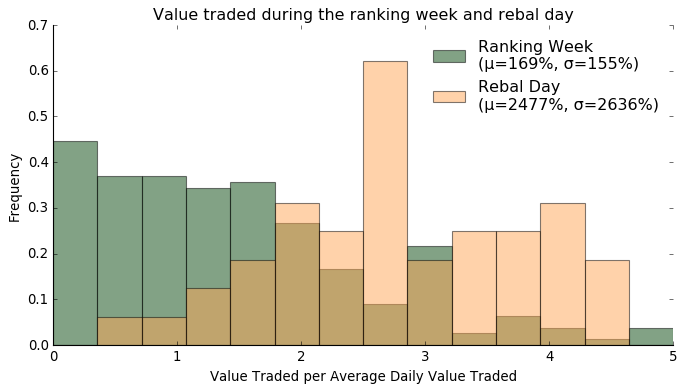

In [667]:
plt.style.use('classic')

time_range = [-7,0]

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
    
t0 = df[df['d']==time_range[0]][['ticker','rebal_date','flag','px']]
t1 = df[df['d']==time_range[1]][['ticker','px']]
delta = pd.merge(left=t0,right=t1, on=['ticker'], suffixes=['0','1'])
delta['dpx'] = delta['px1']-delta['px0']
delta['return'] = -delta['dpx']/delta['px0']*delta['flag']

bins = np.linspace(0, 5,15)

plt.hist(adv_ranking['pct_adv_ranking'], color='xkcd:forest green', alpha=0.5, bins=bins, density=True)
plt.hist(adv_ranking['pct_adv_rebal'], color='xkcd:pale orange', alpha=0.5, bins=bins, density=True)
    
plt.legend(['Ranking Week\n(μ={Mean}%, σ={Std}%)'.format(Mean=int(round(adv_ranking['pct_adv_ranking'].mean(),2)*100),
                                                          Std=int(round(adv_ranking['pct_adv_ranking'].std(),2)*100)),
            'Rebal Day\n(μ={Mean}%, σ={Std}%)'.format(Mean=int(round(adv_ranking['pct_adv_rebal'].mean(),2)*100),
                                                         Std=int(round(adv_ranking['pct_adv_rebal'].std(),2)*100))], 
            frameon=False, loc='best')
    
plt.title('Value traded during the ranking week and rebal day')
plt.xlabel('Value Traded per Average Daily Value Traded')
plt.ylabel('Frequency')
plt.ylim([0,0.7])
plt.show()
fig.savefig('\\'.join(overleaf+['ADV.png']))

In [757]:
if 'pct_adv_ranking' in df.columns:
    df.drop(['pct_adv_ranking'], axis=0, inplace=True)
df = df.merge(adv_ranking[['ticker','pct_adv_ranking']].drop_duplicates(), on=['ticker'], how='left')

## How does volatility affect extent or timing of trade pre-positioning?

High vol => trade is compressed. Low vol => trade is spread out (lower cost?) What happens over march break? Typically, wrong-way trades.

In [696]:
risk_product = 'HUV'

vol = allpx[allpx['symbol']==risk_product][['date','px']]
vol.columns = ['date',risk_product]
vol['date'] = pd.to_datetime(vol['date'])

if risk_product in df.columns:
    df.drop([risk_product],axis=0, inplace=True)
    
df = df.merge(vol, left_on=['rebal_date'], right_on=['date'], suffixes=('','_vol'), how='left')

0.0006924080337410674 -0.02432262808550259 0.0019289956248909894


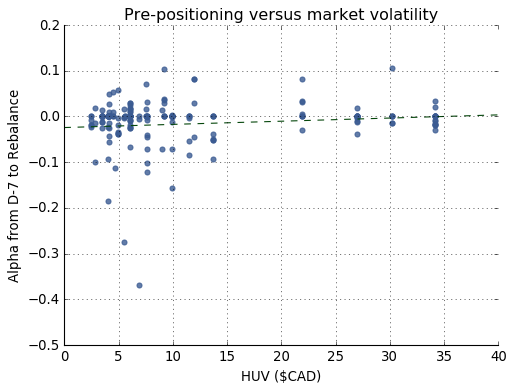

0.03159071117589341 1.2857844288187905 0.04595746342770867


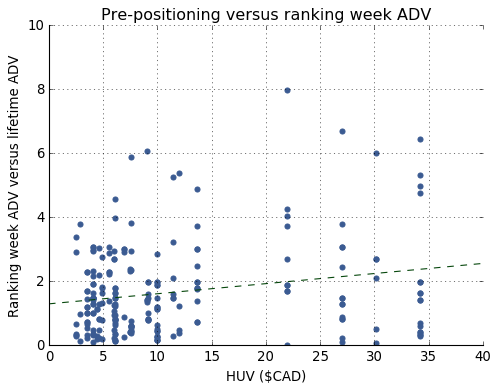

In [797]:
plt.style.use('classic')

fig = plt.figure(figsize=(7,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

days=-7

plt.scatter(df.loc[df['d']==days][risk_product],
            df.loc[df['d']==days]['alpha_to_rebal_side-adj'],
           color='xkcd:denim blue', alpha=0.8)

# Regress it!
slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[(df['d']==days) & (df['alpha_to_rebal_side-adj'].between(-1,1))].dropna()[risk_product],
                                                              (df.loc[(df['d']==days) & (df['alpha_to_rebal_side-adj'].between(-1,1))].dropna()['alpha_to_rebal_side-adj']))

print(slope, intercept, r_value**2)
X = np.linspace(0, 40, 2)
Y = X*slope + intercept
plt.plot(X, Y, color='xkcd:forest green', alpha=1, linestyle='--')

plt.title('Pre-positioning versus market volatility')
plt.ylabel('Alpha from D{Days} to Rebalance'.format(Days=days))
plt.xlabel('{Product} ($CAD)'.format(Product=risk_product))

plt.ylim(-0.5,0.2)
plt.xlim(0,40)
plt.show()
fig.savefig('\\'.join(overleaf+['{RiskProduct}_pre-positioning.png'.format(RiskProduct=risk_product)]))

plt.style.use('classic')

fig = plt.figure(figsize=(7,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

days=-7

plt.scatter(df.loc[df['d']==days][risk_product],
            df.loc[df['d']==days]['pct_adv_ranking'],
           color='xkcd:denim blue')

# Regress it!
slope, intercept, r_value, p_value, std_err = stats.linregress(df.loc[(df['d']==days) & (df['pct_adv_ranking'].between(0,10))].dropna()[risk_product],
                                                              (df.loc[(df['d']==days) & (df['pct_adv_ranking'].between(0,10))].dropna()['pct_adv_ranking']))

print(slope, intercept, r_value**2)
X = np.linspace(0, 40, 2)
Y = X*slope + intercept
plt.plot(X, Y, color='xkcd:forest green', alpha=1, linestyle='--')

plt.title('Pre-positioning versus ranking week ADV')
plt.ylabel('Ranking week ADV versus lifetime ADV')
plt.xlabel('{Product} ($CAD)'.format(Product=risk_product))

plt.ylim(0,10)
plt.xlim(0,40)
plt.show()
fig.savefig('\\'.join(overleaf+['{RiskProduct}_pre-positioning_adv.png'.format(RiskProduct=risk_product)]))


In [801]:
df['has_loc'] = df['date']>pd.to_datetime(datetime.date(year=2015, month=5, day=1))

TypeError: cannot compare a dtyped [bool] array with a scalar of type [bool]

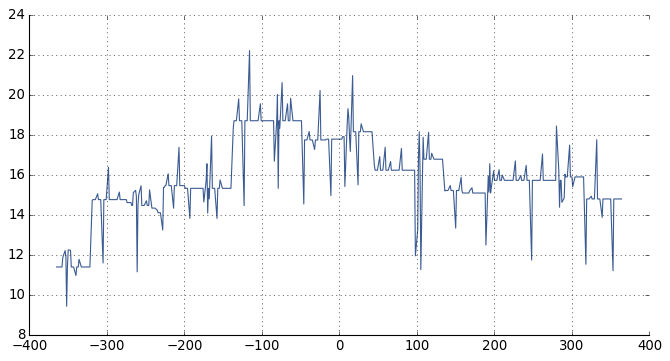

In [806]:
daily_risk = df.groupby(by=['d','has_loc']).agg({risk_product:['mean','std']}).reset_index()
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(daily_risk.loc[daily_risk['d'].between(-365,365) & daily_risk['has_loc']]['d'],
        daily_risk.loc[daily_risk['d'].between(-365,365) & daily_risk['has_loc']][(risk_product,'mean')],
        color='xkcd:denim blue')

ax.fill_between(daily_risk.loc[daily_risk['d'].between(-365,365) & daily_risk['has_loc']]['d'],
                daily_risk.loc[daily_risk['d'].between(-365,365)][(risk_product,'mean') & daily_risk['has_loc']]-daily_risk.loc[daily_risk['d'].between(-365,365) & daily_risk['has_loc']][(risk_product,'std')],
                daily_risk.loc[daily_risk['d'].between(-365,365)][(risk_product,'mean') & daily_risk['has_loc']]+daily_risk.loc[daily_risk['d'].between(-365,365) & daily_risk['has_loc']][(risk_product,'std')],
                color='xkcd:denim blue', alpha=0.1)

ax.legend([risk_product], frameon=False, loc='best')

# Plot the ranking period
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [100,100], color='xkcd:grey', alpha=0.2)
ax.fill_between([-(length_of_ranking_period+avg_days),-length_of_ranking_period], [-100,-100], color='xkcd:grey', alpha=0.2)

plt.title('Buy the Adds, Short the Dels\n{Factor}'.format(Factor=factor.replace('_',' ')))
plt.ylabel('Culmulative returns\nNot side-adjusted')
plt.xlabel('Days Since (To) Rebalance')

plt.xlim(-90,90)
plt.ylim(0,30)
plt.show()
fig.savefig('\\'.join(overleaf+['{RiskProduct}.png'.format(RiskProduct=risk_product)]))

## Did volatility during rebalances after the TSX introduced LOC orders to the MOC facility?

In Apr 2015, TSX made changes to the MOC facility to include LOC orders. Vol probably went down. So, segment out June 2015 onwards.

-6.240306315319355e-05

## Did reversion decrease when S&P changed the benchmark to the 5-day VWAP?

### Is there even reversion?

In [958]:
ranking_reversion = df[['ticker','rebal_px','ranking_px', 'flag','rebal_date','rebal_ranking_end','lifetime_beta']].drop_duplicates()
ranking_reversion['Rm'] = ranking_reversion.apply(lambda row: (threefactor.loc[threefactor['date'].between(row['rebal_ranking_end'], row['rebal_date'])]['Rm']+1).prod()-1, axis=1)
ranking_reversion['RF'] = ranking_reversion.apply(lambda row: (threefactor.loc[threefactor['date'].between(row['rebal_ranking_end'], row['rebal_date'])]['RF']+1).prod()-1, axis=1)

ranking_reversion['return_ranking_to_rebal'] = (ranking_reversion['rebal_px']-ranking_reversion['ranking_px'])/ranking_reversion['ranking_px']
ranking_reversion['return_ranking_to_rebal'] = ranking_reversion['return_ranking_to_rebal']*ranking_reversion['flag']

ranking_reversion['alpha'] = df['return_ranking_to_rebal']-df['RF']-(df['lifetime_beta']*(df['Rm']-df['RF']))

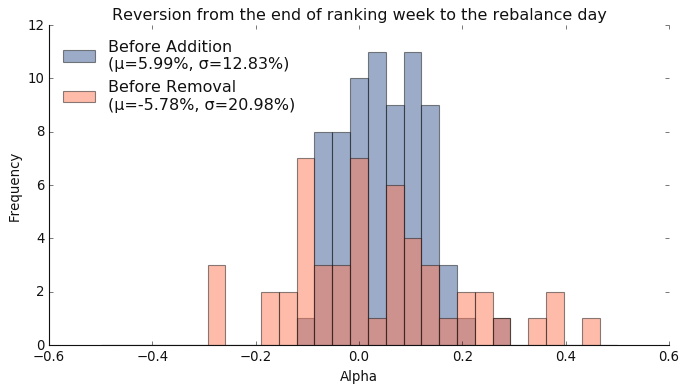

In [967]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-0.5,0.5,30)
plt.hist(ranking_reversion.loc[ranking_reversion['flag']==1]['alpha'], color='xkcd:denim blue', alpha=0.5, bins=bins)
plt.hist(ranking_reversion.loc[ranking_reversion['flag']==-1]['alpha']*-1, color='xkcd:melon', alpha=0.5, bins=bins)
plt.title('Reversion from the end of ranking week to the rebalance day')
plt.xlabel('Alpha')
plt.ylabel('Frequency')

plt.legend(['Before Addition\n(μ={Mean}%, σ={Std}%)'.format(Mean=round(ranking_reversion.loc[ranking_reversion['flag']==1]['alpha'].mean()*100,2),
                                                          Std=round(ranking_reversion.loc[ranking_reversion['flag']==1]['alpha'].std()*100,2)),
           'Before Removal\n(μ={Mean}%, σ={Std}%)'.format(Mean=round(ranking_reversion.loc[ranking_reversion['flag']==-1]['alpha'].mean()*100,2),
                                                          Std=round(ranking_reversion.loc[ranking_reversion['flag']==-1]['alpha'].std()*100,2))],
            frameon=False, loc='best')
plt.show()
fig.savefig('\\'.join(overleaf+['reversion_from_ranking_week.png']))

## Is there an increase in liquidity risk commensurate with abnormal returns?

Does it create additional risk? Does it create additional returns? Factors that drive each of those.

In [107]:
reload(fd)
# Push the config file to Grapevine so we can pull marketstructure data programatically
config = [df[['ticker','rebal_ranking_start','rebal_ranking_end']].drop_duplicates(),
                    df[['ticker','rebal_date','rebal_date']].drop_duplicates()]
config[0].columns, config[1].columns = ['symbol','start_date','end_date'], ['symbol','start_date','end_date']
config = pd.concat(config).sort_values(by='symbol')
fd.to_grapevine(df=config,filename='user/files/aggregated/config.csv')

In [234]:
# Pull the market structure data from Grapevine
liquidity_factors = []
for file in fd.list_files(subdir='user/files/aggregated'):
    if ('summary-statistics' in file) and ('.pkl' in file):
        liquidity_factors.append(fd.from_grapevine(filename=file))
liquidity_factors = pd.concat(liquidity_factors)
display(liquidity_factors.head())

,venue,date,symbol,spread_tw,pct_spread_tw,bid_size_tw,ask_size_tw,depth_tw,has_bid_tw,has_ask_tw,two_sided_tw,time_at_nbb,time_at_nbo
0,ALPHA,2018-02-15,ACB,0.026947,0.002467,2651.412094,2868.301741,5519.660567,1.0,0.999964,0.999964,0.027103,0.027103
1,ALPHA,2018-02-16,ACB,0.036190,0.003577,2641.547399,2394.451594,5035.962135,1.0,0.999975,0.999975,0.029739,0.029739
2,ALPHA,2018-02-20,ACB,0.023884,0.002224,2596.851473,2942.736052,5539.537269,1.0,0.999966,0.999966,0.045044,0.045044
3,ALPHA,2018-02-21,ACB,0.028695,0.002658,2877.215648,2827.461500,5704.643302,1.0,0.999989,0.999989,0.036471,0.036471
4,ALPHA,2018-02-22,ACB,0.026743,0.002492,2501.592803,2861.652410,5363.245213,1.0,1.000000,1.000000,0.035999,0.035999


### Demonstrate changes in liquidity patterns for a single security

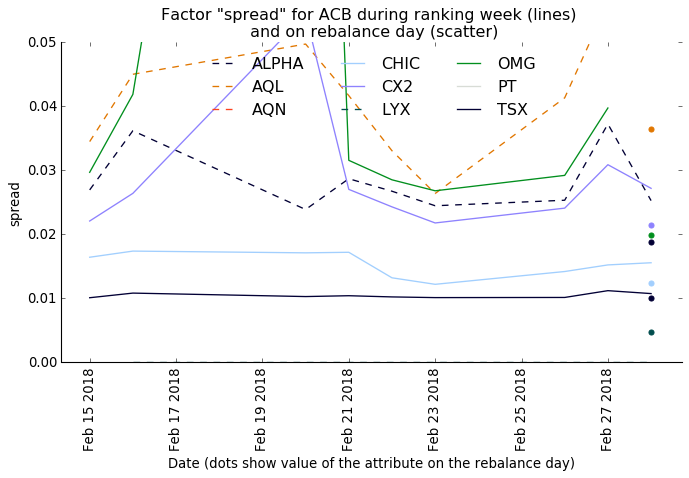

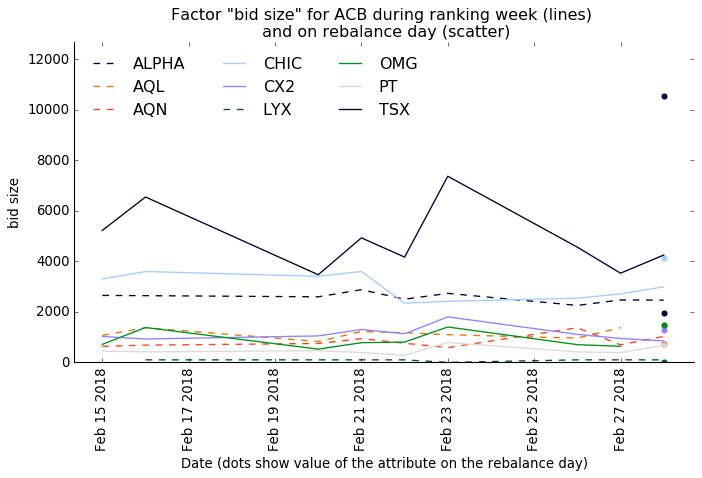

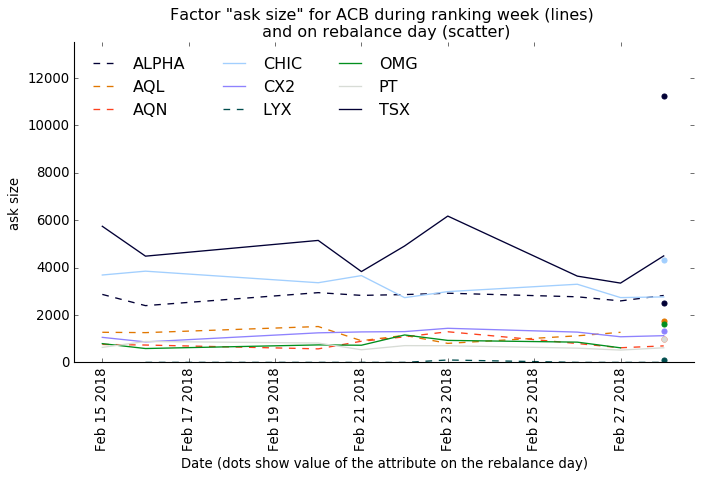

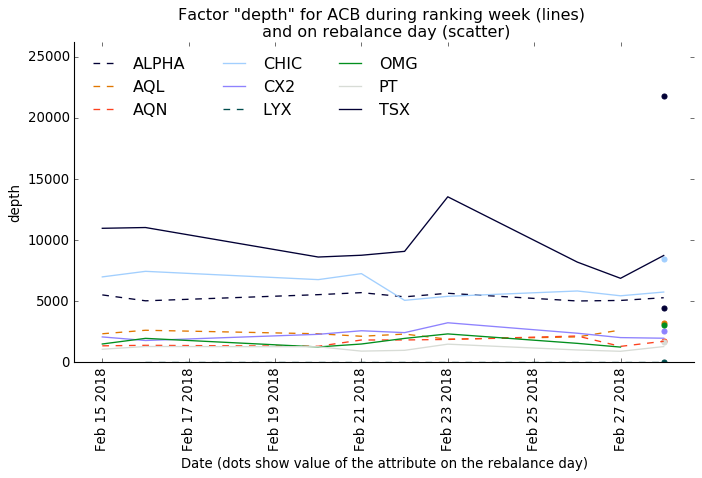

In [301]:
exchange_colors = {'ALPHA':'#020035',
                  'AQL':'#e17701',
                  'AQN':'#fd411e',
                  'CHIC':'#a2cffe',
                  'CX2':'#8e82fe',
                  'LYX':'#014d4e',
                  'OMG':'#028f1e',
                  'PT':'#d8dcd6',
                  'TSX':'#020035'}
symbol = 'ACB'

factors = ['spread_tw','bid_size_tw','ask_size_tw','depth_tw']

acb_lq = liquidity_factors.loc[liquidity_factors['symbol']==symbol]

for factor in factors:
    plt.style.use('classic')

    fig = plt.figure(figsize=(10,5))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)

    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)


    for venue in acb_lq['venue'].unique():

        ranking_week = (acb_lq['venue']==venue) & (acb_lq['date']!=acb_lq['date'].max())
        rebal_day = (acb_lq['venue']==venue) & (acb_lq['date']==acb_lq['date'].max())
        plot_rebal_day_at = acb_lq.loc[ranking_week]['date'].max()

        linestyle = '-' if venue in protected_venues else '--'

        plt.plot(acb_lq.loc[ranking_week, 'date'],
                 acb_lq.loc[ranking_week, factor],
                 color=exchange_colors[venue], linewidth=1.2, linestyle=linestyle)

        plt.scatter(plot_rebal_day_at,
                    acb_lq.loc[rebal_day, factor].values,
                    color=exchange_colors[venue])

    #plt.xticks(acb_lq.loc[acb_lq['venue']=="TSX", 'date'], acb_lq.loc[acb_lq['venue']=="TSX", 'date'], rotation='vertical')
    plt.legend(acb_lq['venue'].unique(),frameon=False, loc='best', ncol=3)
    plt.xticks(rotation=90)
    plt.ylim(0, acb_lq[factor].max()*1.2)
    
    if factor=='spread_tw':
        plt.ylim(0, min(acb_lq[factor].max()*1.2, 0.05))
    
    nice_factor = factor.replace('_tw','').replace('_',' ')
    
    plt.title('Factor "{Factor}" for {Symbol} during ranking week (lines) \n and on rebalance day (scatter)'.format(Factor=nice_factor,
                                                                                                           Symbol=symbol))
    plt.ylabel('{Factor}'.format(Factor=nice_factor))
    plt.xlabel('Date (dots show value of the attribute on the rebalance day)')
    plt.show()

    fig.savefig('\\'.join(overleaf+['{Factor}_during-rebal_{Symbol}.png'.format(Factor=factor, Symbol=symbol)]))

## Do betas change when the stock is added/removed?

In [186]:
beta_changes = df[['ticker','flag','timespan','beta']].loc[df['timespan']!='event'].drop_duplicates()
adds = beta_changes.loc[beta_changes['flag']==1]
dels = beta_changes.loc[beta_changes['flag']==-1]

adds = pd.pivot_table(adds, columns=['timespan'], values=['beta'], index=['ticker'], aggfunc='max').reset_index().dropna()
dels = pd.pivot_table(dels, columns=['timespan'], values=['beta'], index=['ticker'], aggfunc='max').reset_index().dropna()

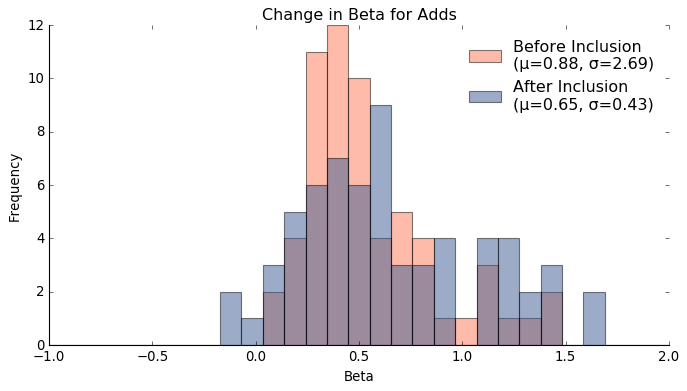

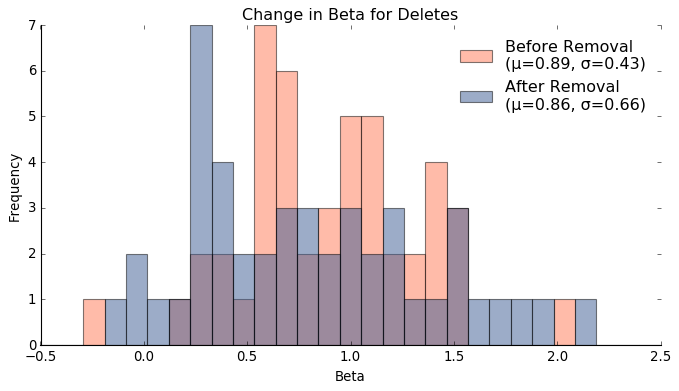

In [327]:
plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-1,2,30)
plt.hist(adds[('beta','pre-event')], color=flag_colors[-1], alpha=0.5, bins=bins)
plt.hist(adds[('beta','post-event')], color=flag_colors[1], alpha=0.5, bins=bins)
plt.title('Change in Beta for Adds')
plt.xlabel('Beta')
plt.ylabel('Frequency')

plt.legend(['Before Inclusion\n(μ={Mean}, σ={Std})'.format(Mean=round(adds[('beta','pre-event')].mean(),2),
                                                          Std=round(adds[('beta','pre-event')].std(),2)),
            'After Inclusion\n(μ={Mean}, σ={Std})'.format(Mean=round(adds[('beta','post-event')].mean(),2),
                                                         Std=round(adds[('beta','post-event')].std(),2))], 
            frameon=False, loc='best')
plt.show()
fig.savefig('\\'.join(overleaf+['beta-change-on-adds.png']))

plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-0.5,2.5,30)
plt.hist(dels[('beta','pre-event')], color=flag_colors[-1], alpha=0.5, bins=bins)
plt.hist(dels[('beta','post-event')], color=flag_colors[1], alpha=0.5, bins=bins)
plt.title('Change in Beta for Deletes')
plt.xlabel('Beta')
plt.ylabel('Frequency')

plt.legend(['Before Removal\n(μ={Mean}, σ={Std})'.format(Mean=round(dels[('beta','pre-event')].mean(),2),
                                                          Std=round(dels[('beta','pre-event')].std(),2)),
            'After Removal\n(μ={Mean}, σ={Std})'.format(Mean=round(dels[('beta','post-event')].mean(),2),
                                                         Std=round(dels[('beta','post-event')].std(),2))], 
            frameon=False, loc='best')
plt.show()
fig.savefig('\\'.join(overleaf+['beta-change-on-dels.png']))

# Let's do some machine learning

In [811]:
import keras
import sklearn as sk
import tensorflow as tf
import xgboost as xgb

#from imblearn.over_sampling import RandomOverSampler

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from yellowbrick.regressor import ResidualsPlot, PredictionError

from numpy.random import seed
SEED = 0xDEADBEEF
seed(SEED)
from tensorflow import set_random_seed
set_random_seed(SEED)

In [1040]:
df['value_traded'] = df['vol']*df['px']
df['is_ranking_week'] = df['date'].between(df['rebal_ranking_start'], df['rebal_ranking_end'])
df['is_measurement_week'] = df['date'].between(df['rebal_ranking_start']-pd.Timedelta(days=8),
                                               df['rebal_ranking_start']-pd.Timedelta(days=1))
#df['is_measurement_week'] = df['is_measurement_week'].apply(lambda boolean: 1 if boolean else 0)
#df['is_ranking_week'] = df['is_ranking_week'].apply(lambda boolean: 1 if boolean else 0)

df['action_after_this_measurement_week'] = df['is_measurement_week']*df['flag']
df['add_after_this_measurement_week'] = df.apply(lambda row: row['is_measurement_week'] if row['flag']==1 else False, axis=1)

df['last_month_start'] = df['date'].apply(lambda date: (date-pd.Timedelta(days=30)).replace(day=1))

In [1085]:
df.columns

Index(['date', 'ticker', 'px', 'vol', 'trades', 'rebal_date', 'rebal_px',
       'flag', 'd', 'delta_px', 'return_to_rebal', 'daily_return', 'Rm', 'RF',
       'culm_Rm', 'timespan', 'beta', 'lifetime_beta', 'daily_alpha',
       'culm_alpha', 'culm_alpha_at_t0', 'alpha_to_rebal',
       'alpha_to_rebal_side-adj', 'return_to_rebal_side-adj', 'rebal_last_eom',
       'rebal_ranking_end', 'rebal_ranking_start', 'ranking_px',
       'return_ranking_to_rebal', 'value_traded', 'is_ranking_week',
       'is_measurement_week', 'action_after_this_measurement_week',
       'last_month_start', 'add_after_this_measurement_week'],
      dtype='object')

## Try a random forest

In [1093]:
X_features = {'px':['mean'],
              'value_traded':['sum'],
              'daily_alpha':['prod','std'],
              'trades':['sum'],
              'beta':['mean']}

y_feature = {'add_after_this_measurement_week':['max']}

group_by = ['ticker','last_month_start']

df_train = df.groupby(by=group_by).agg(X_features).reset_index()#.drop(group_by, axis=1)
df_train = df_train.merge(df.groupby(by=group_by).agg(y_feature).reset_index(), on=group_by, how='outer')
df_train.columns = ['_'.join(column) for column in df_train.columns]

df_train.dropna(inplace=True)

# Determine the columns to select
X_cols = []
y_col = []
for key in X_features.keys():
    for aggfunc in X_features[key]:
        X_cols.append('_'.join([key,aggfunc]))
        
for key in y_feature.keys():
    for aggfunc in y_feature[key]:
        y_col.append('_'.join([key,aggfunc]))
        
# Build the vectors for training
df_test = df_train.sample(n=math.floor(len(df_train.index)*0.25))
df_train = df_train.loc[~df_train.index.isin(df_test.index)]

X_train, X_test = df_train[X_cols], df_test[X_cols]
y_train, y_test = df_train[y_col], df_test[y_col]

# Train the random forest
rf = RandomForestRegressor(n_estimators=1000, max_depth=4, random_state=SEED)
rf.fit(X_train, y_train)
y_predicted = rf.predict(X_test)

### Evaluate the RF Model

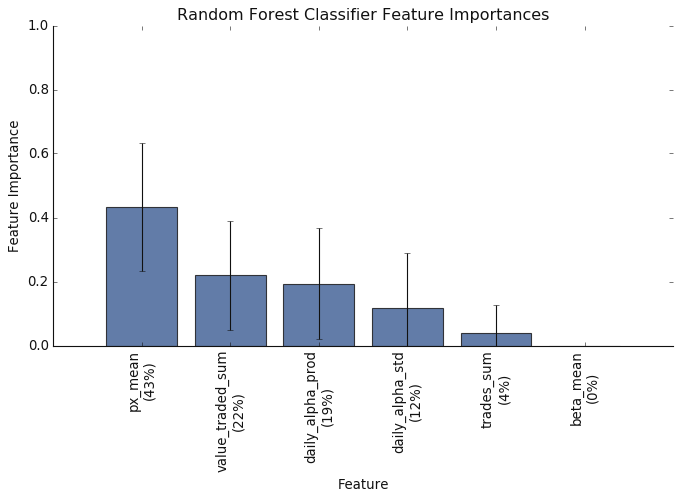

In [1110]:
threshold = 0.5

y_predicted_binary = [y>=threshold for y in y_predicted]

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# PFeature rankings
legend = []
for f in range(X_train.shape[1]):
    legend.append('{Feature}\n({Importance}%)'.format(Feature=X_cols[f], Importance=int(round(importances[indices[f]]*100))))

plt.style.use('classic')

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-1,2,30)
plt.title("Random Forest Classifier Feature Importances")
plt.xlabel('Feature')
plt.ylabel('Feature Importance')

plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center",
       color='xkcd:denim blue', alpha=0.8)
plt.xticks(range(X_train.shape[1]), legend, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylim(0,1)

plt.show()
fig.savefig('\\'.join(overleaf+['rf_feature-importances.png']))

Explained Variance Score: -107.5217453506555
Mean Squared Error: 0.007494080369487226


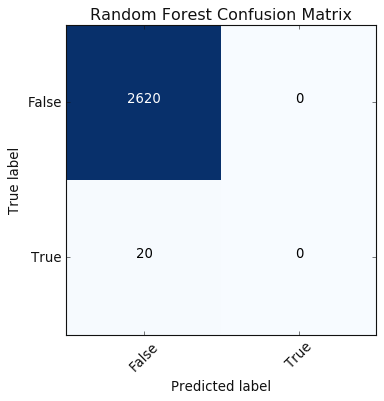

In [1111]:
# Test the model

print('Explained Variance Score: {0}'.format(explained_variance_score(y_predicted, y_test)))
print('Mean Squared Error: {0}'.format(mean_squared_error(y_predicted, y_test)))

plt.style.use('classic')

fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)

bins = np.linspace(-1,2,30)
plt.title("Random Forest Confusion Matrix")

cm = confusion_matrix(list(y_test.iloc[:,0].values), y_predicted_binary)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

tick_marks = np.arange(len(y_test.iloc[:,0].unique()))
plt.xticks(tick_marks, y_test.iloc[:,0].unique(), rotation=45)
plt.yticks(tick_marks, y_test.iloc[:,0].unique())

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
fig.savefig('\\'.join(overleaf+['rf_confusion.png']))

### Try a gradient boosted tree

In [824]:
xgb_regr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                            colsample_bytree=1, max_depth=8)
xgb_regr.fit(X_train, y_train)

In [74]:
hdf.close()
conn.close()